# Bootstrap and Confidence Interval

In this notebook, we investigate parameters of our linear regression model by bootstrapping and finding confidence interval.

## Preliminary

This section contains code to generate data sets and models. Bootstrap and confidence interval can then use them.

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import copy as cp
import os
import requests, zipfile, io
import warnings
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

In [4]:
air_quality = pd.read_csv('us_air_quality_measures.csv', ',')
daily_global_weather = pd.read_csv('daily_global_weather_2020.csv', ',')

In [5]:
import sys
!{sys.executable} -m pip install reverse_geocoder

### Part 1: Combining Datasets and Analysis

#### Global Weather Dataset

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import reverse_geocoder as rg

pd.set_option('mode.chained_assignment', None)

print(daily_global_weather["Unnamed: 0"].unique() == daily_global_weather.index.to_list())
daily_global_weather_new = daily_global_weather.drop(columns=["Unnamed: 0"])
daily_global_weather_new.head()


daily_global_weather_US = daily_global_weather_new[daily_global_weather_new["Station"].str[0:2] == "US"]
daily_global_weather_US.head()


daily_global_weather_US.loc[:, "TEMP_C"] = daily_global_weather_US.loc[:, "TAVG"] / 10.0

daily_global_weather_US["Datetime"] = pd.to_datetime(daily_global_weather_US["Date"], format="%Y-%m-%d")

daily_global_weather_US.loc[:, "PRCP_Millimeter"] = daily_global_weather_US.loc[:, "PRCP"] / 10.0

daily_global_weather_US_final = daily_global_weather_US[["Station", "Latitude", "Longitude",
                                                  "Elevation", "TEMP_C", "Datetime",
                                                  "PRCP_Millimeter"]]
daily_global_weather_US_final.head()


def visualize_uni_distribution(df, name, ax, trans=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        eps = 1e-10
        sns.distplot(np.log10(df[name] + eps), ax=ax)


daily_global_weather_US_final["year"] = daily_global_weather_US_final["Datetime"].dt.year
daily_global_weather_US_final["month"] = daily_global_weather_US_final["Datetime"].dt.month
daily_global_weather_US_final["week"] = daily_global_weather_US_final["Datetime"].dt.week
daily_global_weather_US_final["day"] = daily_global_weather_US_final["Datetime"].dt.day

geo_cord = []
geo_cord = list(daily_global_weather_US_final[['Latitude', 'Longitude']].itertuples(index=False, name=None))
# use rg to search
res = rg.search(geo_cord)

states, county = [], []
for i in res:
    states.append(i["admin1"])
    county.append(i["admin2"])

daily_global_weather_US_final["state"] = states
daily_global_weather_US_final["county"] = county
daily_global_weather_US_final

[ True  True  True ...  True  True  True]
Loading formatted geocoded file...


,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,week,day,state,county
2542,USS0003E03S,44.1100,-103.9800,2100.1,-0.8,2020-01-01,5.1,2020,1,1,1,South Dakota,Lawrence County
2543,USS0003E05S,44.2100,-103.7900,1868.4,1.5,2020-01-01,2.5,2020,1,1,1,South Dakota,Lawrence County
2544,USS0004E07S,44.4900,-104.4100,1801.4,1.4,2020-01-01,5.1,2020,1,1,1,Wyoming,Crook County
2545,USS0005G04S,42.4400,-105.8600,2552.7,-4.9,2020-01-01,2.5,2020,1,1,1,Wyoming,Converse County
2546,USS0005G05S,42.2800,-105.5800,2407.9,-4.2,2020-01-01,0.0,2020,1,1,1,Wyoming,Converse County
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064278,USW00094847,42.2314,-83.3308,192.3,9.6,2020-10-22,15.7,2020,10,43,22,Michigan,Wayne County
1064279,USW00094849,45.0717,-83.5644,208.5,6.7,2020-10-22,9.9,2020,10,43,22,Michigan,Alpena County
1064280,USW00094860,42.8939,-85.5447,237.1,7.7,2020-10-22,16.5,2020,10,43,22,Michigan,Kent County
1064281,USW00094908,42.3978,-90.7036,321.9,7.3,2020-10-22,36.1,2020,10,43,22,Iowa,Dubuque County


In [7]:
# select Alameda County
state_name = 'California'
weather_county = daily_global_weather_US_final[(daily_global_weather_US_final['state'] == state_name) &
                                              (daily_global_weather_US_final['county'] == 'Alameda County')]
weather_county = weather_county.groupby(['Datetime']).mean()
weather_county = weather_county.reset_index()
weather_county['Datetime'] = pd.to_datetime(weather_county['Datetime'])
weather_county

,Datetime,Latitude,Longitude,Elevation,TEMP_C,PRCP_Millimeter,year,month,week,day
0,2020-01-02,37.6542,-122.115,13.1,10.6,0.0,2020.0,1.0,1.0,2.0
1,2020-01-03,37.6542,-122.115,13.1,10.0,0.0,2020.0,1.0,1.0,3.0
2,2020-01-04,37.6542,-122.115,13.1,10.5,0.0,2020.0,1.0,1.0,4.0
3,2020-01-05,37.6542,-122.115,13.1,9.1,0.0,2020.0,1.0,1.0,5.0
4,2020-01-06,37.6542,-122.115,13.1,9.2,0.0,2020.0,1.0,2.0,6.0
...,...,...,...,...,...,...,...,...,...,...
290,2020-10-18,37.6542,-122.115,13.1,22.4,0.0,2020.0,10.0,42.0,18.0
291,2020-10-19,37.6542,-122.115,13.1,19.1,0.0,2020.0,10.0,43.0,19.0
292,2020-10-20,37.6542,-122.115,13.1,19.2,0.0,2020.0,10.0,43.0,20.0
293,2020-10-21,37.6542,-122.115,13.1,20.3,0.0,2020.0,10.0,43.0,21.0


#### AQI Dataset

In [10]:
epa_weburl = "https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_co...
1,daily_county_aqi,daily_aqi_by_cou...
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


In [11]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

In [12]:
# add month and date
daily_county = epa_data.get('daily_county_aqi')
daily_county_datetime = pd.to_datetime(daily_county['Date'])
daily_county['Month'] = pd.DatetimeIndex(daily_county_datetime).month
daily_county['day'] = pd.DatetimeIndex(daily_county_datetime).day
daily_county['Date'] = pd.to_datetime(daily_county['Date'])
AQI_county = daily_county[daily_county['county Name'] == 'Alameda']
AQI_county = AQI_county.reset_index()
AQI_county.head()

,index,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,day
0,14197,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
1,14198,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
2,14199,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
3,14200,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
4,14201,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


From the above plot, we can see that there "should" be a seasonal relationship. The above plot indicates that, to capture the change in AQI, we need to gather features such as seasonal temperature and precipitation to better fit the model.

#### Combine Datasets and Construct final dataframe

In [ ]:
# select Alameda County
AQI_county = daily_county[daily_county['county Name'] == 'Alameda']
data_merged = pd.merge(AQI_county, weather_county, left_on='Date', right_on='Datetime')
data_final = data_merged[['Date', 'AQI', 'TEMP_C', 'PRCP_Millimeter']]
data_final['prev_1'] = data_final.AQI.shift(1)
data_final['prev_2'] = data_final.AQI.shift(2)
data_final = data_final.dropna()
data_final

In [15]:
# drop Date column
data_final = data_final.drop(columns=['Date'])

Then we normalize the features.

In [16]:
final_df_normalized = (data_final.iloc[:, :] - np.mean(data_final.iloc[:, :], axis=0)) / np.std(data_final.iloc[:, :], axis=0)
final_df_normalized
# retrieve the ys
final_df_normalized_with_y = final_df_normalized.copy()
final_df_normalized_with_y = final_df_normalized_with_y[["TEMP_C", "PRCP_Millimeter", "prev_1", "prev_2"]]
final_df_normalized_with_y["AQI"] = data_final["AQI"]
final_df_normalized_with_y

,TEMP_C,PRCP_Millimeter,prev_1,prev_2,AQI
2,-1.341833,-0.222182,0.671018,-0.297000,45
3,-1.658403,-0.222182,-0.235587,0.671984,33
4,-1.635790,-0.222182,-0.610734,-0.234485,35
5,-1.726239,-0.222182,-0.548210,-0.609575,49
6,-1.341833,-0.222182,-0.110538,-0.547060,36
...,...,...,...,...,...
290,1.349010,-0.222182,0.170822,-0.328258,61
291,0.602810,-0.222182,0.264609,0.171863,49
292,0.625422,-0.222182,-0.110538,0.265636,46
293,0.874155,-0.222182,-0.204325,-0.109455,53


### Modeling

#### Construct window slider

In [20]:
class WindowSlider(object):
# referenced from: https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe    
    
    def __init__(self, window_size):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        '''
        Helper function to initializate to 0 a vector
        '''
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size, offset=0, previous_y=False):
        '''
        Input: X is the input matrix, each column is a variable
        Returns: diferent mappings window-output
        '''
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

#### Utilities

In [21]:
def evaluate_rmse(y, y_pred, model_name, status, suppress=False):
    # sanity check
    assert len(y) == len(y_pred)
    rmse = np.sqrt(np.sum(np.power(y_pred - y,2)) / len(y_pred - y))
    if not suppress:
        print('%s RMSE of %s = %.2f' % (status, model_name, rmse))
    return rmse

In [22]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")

In [23]:
def plot_y_and_ypred(train_df, y_train, y_train_pred, test_df, y_test, y_test_pred, model_name):
    fig, axs = plt.subplots(1,2, figsize=(24,6))
    plot_train_df = train_df.copy()
    plot_test_df = test_df.copy()
    
    plot_train_df['y_pred'] = y_train_pred
    plot_test_df['y_pred'] = y_test_pred
    if "AQI" in plot_train_df.columns:
        axs[0].plot(plot_train_df["AQI"], label = 'AQI')    
        axs[0].plot(plot_train_df["y_pred"], label = 'pred')
        axs[0].legend()
        axs[0].set_xlabel("days");
        axs[0].set_ylabel("daily AQI");
        axs[0].set_title("y and y_pred on training set");
        
        axs[1].plot(plot_test_df["AQI"], label = 'AQI')
        axs[1].plot(plot_test_df["y_pred"], label = 'pred')
        axs[1].legend()
        axs[1].set_xlabel("days");
        axs[1].set_ylabel("daily AQI");
        axs[1].set_title("y and y_pred on testing set");
        
    else:
        axs[0].plot(plot_train_df["Y"], label = 'Y')
        axs[0].plot(plot_train_df["y_pred"], label = 'pred')
        axs[0].legend()
        axs[0].set_xlabel("days");
        axs[0].set_ylabel("daily AQI");
        axs[0].set_title("y and y_pred on training set using sliding window");
    
        axs[1].plot(plot_test_df["Y"], label = 'Y')
        axs[1].plot(plot_test_df["y_pred"], label = 'pred')
        axs[1].legend()
        axs[1].set_xlabel("days");
        axs[1].set_ylabel("daily AQI");
        axs[1].set_title("y and y_pred on testing set using sliding window");
    
    # formatting
    plt.suptitle("Actual and predicted AQI values using %s" % model_name);

#### Train Test Split

In [24]:
split_point = int(0.8 * final_df_normalized_with_y.shape[0])
tn = final_df_normalized_with_y.iloc[0:split_point, :]
vd = final_df_normalized_with_y.iloc[split_point+1:, :]

In [25]:
shuffle=False

if shuffle:
    np.random.seed(1)
    # shuffle the training set
    train_indicies = tn.index.to_list()
    # random shuffle the sequence
    np.random.shuffle(train_indicies)

    # apply the same shuffled sequence to both training data and training labels
    train_shuffled = tn.loc[train_indicies, :]

    shuffled_data = train_shuffled.iloc[:, :-1]
    shuffled_labels = train_shuffled.iloc[:, -1]
else:
    shuffled_data = tn.iloc[:, :-1]
    shuffled_labels = tn.iloc[:, -1]    

#### Multiple Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

class MultipleLinearRegression:
    
    def __init__(self, window_size, tn_data, vd_data, with_y_inc=False, 
                 ):
        self.window_size = window_size
        self.with_y_inc = with_y_inc
        
        if self.with_y_inc:
            self.tn_data = WindowSlider(self.window_size).collect_windows(tn_data.iloc[:,0:], previous_y=True, 
                                                          window_size=self.window_size)
            self.vd_data = WindowSlider(self.window_size).collect_windows(vd_data.iloc[:,0:], previous_y=True, 
                                                          window_size=self.window_size)
        else:
            self.tn_data = WindowSlider(self.window_size).collect_windows(tn_data.iloc[:,0:], previous_y=False, 
                                                          window_size=self.window_size)
            self.vd_data = WindowSlider(self.window_size).collect_windows(vd_data.iloc[:,0:], previous_y=False, 
                                                          window_size=self.window_size)    
                                                    
        
        self.model = LinearRegression(fit_intercept=True)
        
    def train(self): 
        self.model.fit(self.tn_data_X, self.tn_data_Y)
    
    def get_XY(self):
        return self.tn_data, self.tn_data_X, self.tn_data_Y, self.vd_data, self.vd_data_X, self.vd_data_Y
    
    def predict(self, X):
        return self.model.predict(X)
    def get_params(self):
        return self.model.coef_

In [27]:
w = 1
train_constructor = WindowSlider(w)
train_windows = train_constructor.collect_windows(tn.iloc[:,:-2],w, 
                                                  previous_y=False)

test_constructor = WindowSlider(w)
test_windows = test_constructor.collect_windows(vd.iloc[:,:-2],w,
                                                previous_y=False)

train_constructor_y_inc = WindowSlider(w)
train_windows_y_inc = train_constructor_y_inc.collect_windows(tn.iloc[:,:-2],w, 
                                                  previous_y=True)

test_constructor_y_inc = WindowSlider(w)
test_windows_y_inc = test_constructor_y_inc.collect_windows(vd.iloc[:,:-2],w,
                                                previous_y=True)

train_windows.head()

,TEMP_C(1),PRCP_Millimeter(1),∆t(2),Y
0,0.0,-0.222182,-1.658403,-0.235587
1,0.0,-0.222182,-1.635790,-0.610734
2,0.0,-0.222182,-1.726239,-0.548210
3,0.0,-0.222182,-1.341833,-0.110538
4,0.0,-0.222182,-1.273996,-0.516947


In [28]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(tn.iloc[:,:-1], tn.iloc[:,-1])

lr_y = vd['AQI'].values
lr_y_fit = lr_model.predict(tn.iloc[:,:-1])
lr_y_pred = lr_model.predict(vd.iloc[:,:-1])

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

eval_metrics(lr_y, lr_y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.60530846204608
MAE 		: 21.767752124346774
MSE 		: 938.4921183912264
RMSE 		: 30.63481872626679


In [30]:
lr_wd_model = LinearRegression()
lr_wd_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

lr_wd_y = test_windows['Y'].values
lr_wd_y_fit = lr_wd_model.predict(train_windows.iloc[:,:-1])
lr_wd_y_pred = lr_wd_model.predict(test_windows.iloc[:,:-1])

lr_wd_residuals = lr_wd_y_pred - lr_wd_y
lr_wd_rmse = np.sqrt(np.sum(np.power(lr_wd_residuals,2)) / len(lr_wd_residuals))

eval_metrics(test_windows.iloc[:,-1], lr_wd_y_pred)

Model testing performance:
--------------------------
R2_score 	: -0.31331399506390345
MAE 		: 1.2125759990757228
MSE 		: 3.0898502903644105
RMSE 		: 1.7577969991908653


#### Regularization - Ridge

In [32]:
X_train=tn.iloc[:,0:-1]
X_test=vd.iloc[:,0:-1]
feature=tn.iloc[:,0:-1].columns
print (feature)
y_train=tn.iloc[:,-1]
y_test=vd.iloc[:,-1]

Index(['TEMP_C', 'PRCP_Millimeter', 'prev_1', 'prev_2'], dtype='object')


In [ ]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
eval_metrics(y_test, y_pred_ridge)

y_train_pred_ridge = ridge_model.predict(X_train)
eval_metrics(y_train, y_train_pred_ridge)

Model testing performance:
--------------------------
R2_score 	: 0.6029111128929308
MAE 		: 21.787925678912128
MSE 		: 944.1925022832296
RMSE 		: 30.727715539610646
Model testing performance:
--------------------------
R2_score 	: 0.6498392116335445
MAE 		: 7.780510713597961
MSE 		: 155.23107495935335
RMSE 		: 12.459176335510842


In [ ]:
ridge_model = Ridge(alpha=1)
scores = cross_validate(ridge_model, X_train, y_train,
                    scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:]

,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,-1.178852,-7.674687,-97.987819,-9.898880
2,-0.585669,-8.817448,-107.558446,-10.371039
3,0.174763,-5.539836,-60.305304,-7.765649
4,-0.386956,-3.122076,-16.990216,-4.121919
5,-0.303750,-6.316045,-71.984762,-8.484383
6,0.089027,-8.838014,-159.483923,-12.628694
7,0.456807,-8.239114,-91.459801,-9.563462
8,-0.143581,-11.358337,-342.322109,-18.501949
9,0.080963,-6.918255,-69.846797,-8.357440
10,0.351485,-24.913651,-1562.493391,-39.528387


In [36]:
alpha_space = np.linspace(0.01, 1, 100)
ridge_cv_model = RidgeCV(alphas = alpha_space, cv = 10, scoring = "neg_root_mean_squared_error")
ridge_cv_model.fit(X_train, y_train)
ridge_cv_model.alpha_
y_pred_ridge_cv = ridge_cv_model.predict(X_test)
eval_metrics(y_test, y_pred_ridge_cv)

Model testing performance:
--------------------------
R2_score 	: 0.6052847493688512
MAE 		: 21.767807766517134
MSE 		: 938.5485020694794
RMSE 		: 30.63573896724999


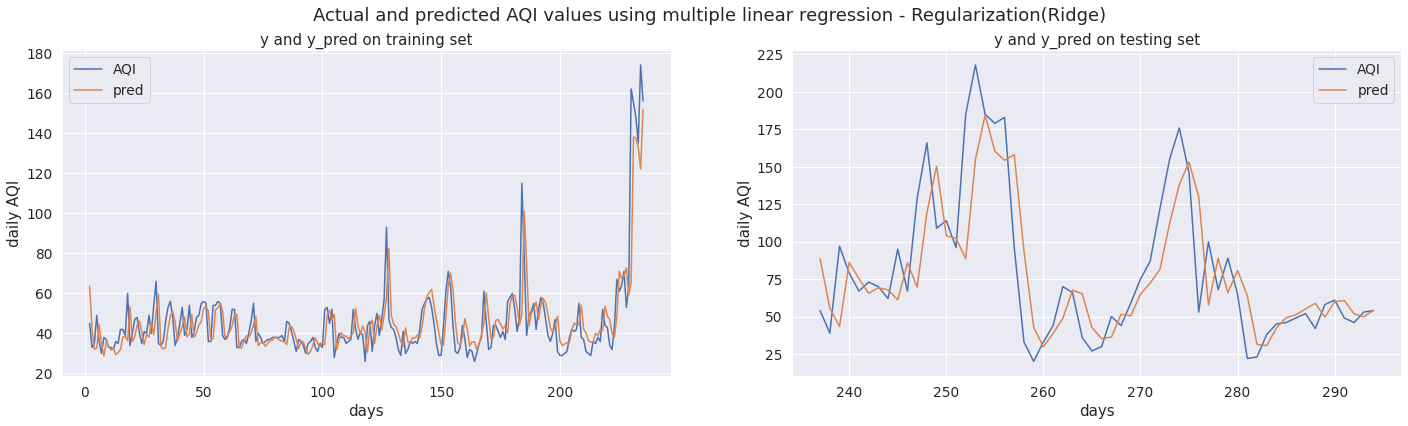

In [37]:
plot_y_and_ypred(tn, y_train, y_train_pred_ridge, vd, y_test, 
                 y_pred_ridge, "multiple linear regression - Regularization(Ridge)")

#### Regularization - Lasso 

In [50]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
eval_metrics(y_test, y_pred_lasso)

Model testing performance:
--------------------------
R2_score 	: 0.5930248528166404
MAE 		: 21.99025932573658
MSE 		: 967.6999157181929
RMSE 		: 31.107875461339255


In [39]:
y_train_pred_lasso = lasso_model.predict(X_train)
eval_metrics(y_train, y_train_pred_lasso)

Model testing performance:
--------------------------
R2_score 	: 0.6428968022616971
MAE 		: 7.716960558582126
MSE 		: 158.30874015032825
RMSE 		: 12.582080120168058


#### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
data_train, data_test= train_test_split(final_df_normalized_with_y,test_size=0.2, random_state=0)
print ("Train set info：\n",data_train.describe().round(2))
print ("Test set info：\n",data_test.describe().round(2))
print ("Train set value：\n",data_train.iloc[:,-1].value_counts())
print ("Test set value：\n",data_test.iloc[:,-1].value_counts())

In [45]:
split_point = int(0.8 * final_df_normalized_with_y.shape[0])
tn_rf = final_df_normalized_with_y.iloc[0:split_point, :]
vd_rf = final_df_normalized_with_y.iloc[split_point+1:, :]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
criterion=['mse','mae']
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'criterion':criterion,
                'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#build model
clf= RandomForestRegressor()
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 10,  
                              cv = 3, verbose=2, random_state=42, n_jobs=1)
#regression
clf_random.fit(X_train, y_train)
print (clf_random.best_params_)

In [48]:
rf=RandomForestRegressor(criterion='mse',bootstrap=False,max_features='sqrt', max_depth=20 ,min_samples_split=10, n_estimators=900,min_samples_leaf=2)

rf.fit(X_train, y_train) 
y_train_pred_rf=rf.predict(X_train)
y_test_pred_rf=rf.predict(X_test)

eval_metrics(y_test, y_test_pred_rf)

Model testing performance:
--------------------------
R2_score 	: 0.36646119466176463
MAE 		: 27.95523589065251
MSE 		: 1506.4198705327783
RMSE 		: 38.812625143537744


## Bootstrap resampling

([3.0498056892166896,
  -0.34762484240126273,
  24.385508610949156,
  0.7159910865604493],
 [1.3745835673968727,
  0.20946229725988846,
  8.673507662713833,
  12.666206906177784])

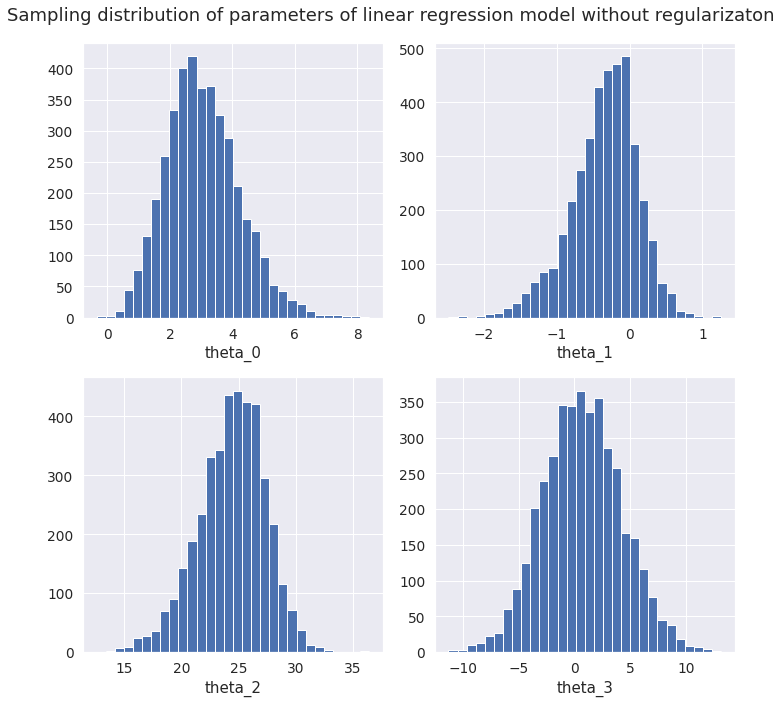

In [51]:
def bootstrap_exp_var_estimate(model, model_name, sample, m=4000):
    '''Estimate the variance of estimator f by the empirical variance'''
    estimates = []
    n = len(sample)
    for j in range(m):
        resample = sample.sample(n=n, replace=True)
        model.fit(resample.iloc[:,:-1], resample.iloc[:,-1])
        estimates.append(model.coef_)
    estimates = np.array(estimates)
    estimates_exp, estimates_var = [], []
    num_params = estimates.shape[1]
    fig, axes = plt.subplots(2,num_params//2, figsize=(10, 10))
    fig.suptitle(f'Sampling distribution of parameters of {model_name}')
    axes = axes.ravel()
    xaxes = ['theta_0', 'theta_1', 'theta_2', 'theta_3']
    for col_idx in range(num_params):  # estimates.shape[1]: number of params of the model
        col = estimates[:, col_idx]
        axes[col_idx].hist(col, bins=30)
        axes[col_idx].set_xlabel(xaxes[col_idx])
        estimates_exp.append(np.mean(col))
        estimates_var.append(np.var(col))
    plt.tight_layout()
    return estimates_exp, estimates_var

bt_times = 4000 # Bootstrap resample times
# models = [lr_model, ridge_model, lasso_model]
bootstrap_exp_var_estimate(lr_model, 'linear regression model without regularizaton', tn, bt_times)

([3.104353533101691,
  -0.35658537545591357,
  23.726708532538026,
  1.2935846456857611],
 [1.4289122119951423,
  0.1993882831312119,
  7.98723487454338,
  12.043158066391733])

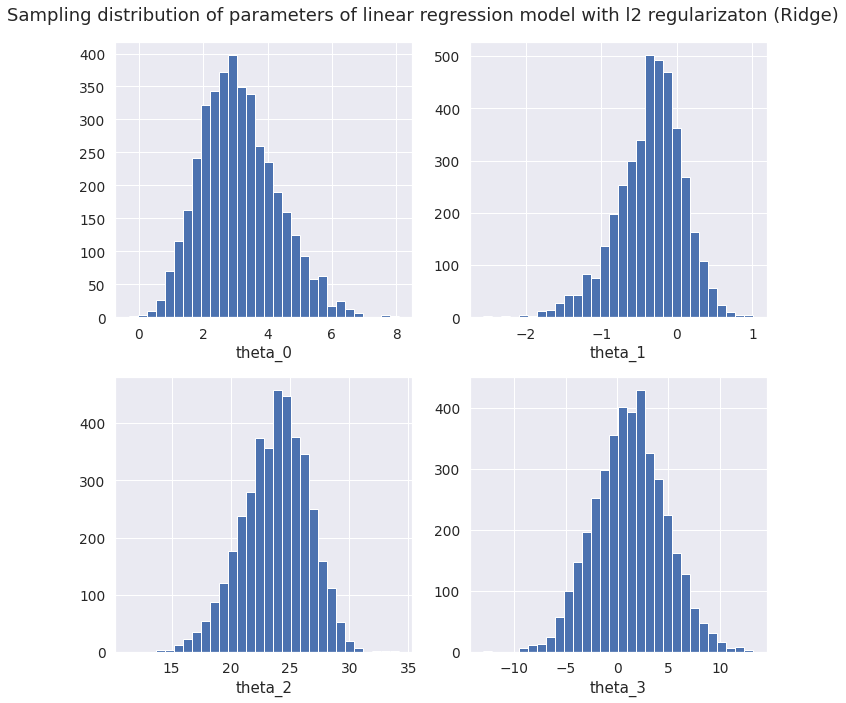

In [57]:
bootstrap_exp_var_estimate(ridge_model, 'linear regression model with l2 regularizaton (Ridge)', tn, bt_times)

([2.5072314649465057,
  -0.04681057440177655,
  21.811686429041757,
  0.8687941559316819],
 [1.301574937076252,
  0.015511217931187147,
  9.109087519555647,
  2.831514271957489])

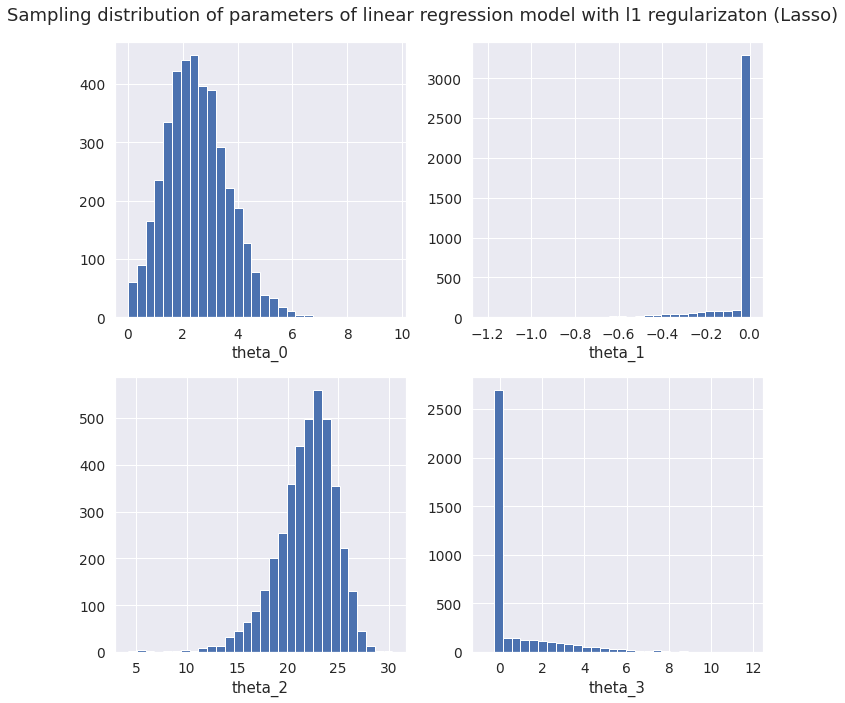

In [59]:
bootstrap_exp_var_estimate(lasso_model, 'linear regression model with l1 regularizaton (Lasso)', tn, bt_times)

## Confidence interval

In [44]:
def ci(sample, estimator, param_idx, confidence=95, m=1000):
    '''Computer a confidence interval for an estimator'''
    if isinstance(sample, np.ndarray):
        sample = pd.Series(sample)
    estimates = []
    n = sample.shape[0]
    for _ in range(m):
        resample = sample.sample(n=n, replace=True)
        estimator.fit(resample.iloc[:,:-1], resample.iloc[:,-1])
        estimates.append(estimator.coef_[param_idx])
    estimates = np.array(estimates)
    slack = 100 - confidence
    lower = np.percentile(estimates, slack / 2)
    upper = np.percentile(estimates, 100 - slack / 2)
    return (lower, upper)

In [51]:
models = {'lr': lr_model, 'ridge': ridge_model, 'lasso': lasso_model}
num_params = 4
for model_name, model in models.items():
    for param_idx in range(num_params):
        print(f'model = {model_name}, param_idx = {param_idx}, ci = {ci(tn, lr_model, param_idx)}')

model = lr, param_idx = 0, ci = (1.0639566243285057, 5.750557284459034)
model = lr, param_idx = 1, ci = (-1.349874670503405, 0.3864856906380695)
model = lr, param_idx = 2, ci = (18.41262391660827, 30.013192182819186)
model = lr, param_idx = 3, ci = (-5.587858025058701, 7.616556190182063)
model = ridge, param_idx = 0, ci = (0.9229361782103855, 5.451480661900191)
model = ridge, param_idx = 1, ci = (-1.4451911249382006, 0.4150256677568945)
model = ridge, param_idx = 2, ci = (18.45909741563524, 29.34993750933851)
model = ridge, param_idx = 3, ci = (-5.794195053365011, 7.992915920366152)
model = lasso, param_idx = 0, ci = (0.9853687506278072, 5.637054047521417)
model = lasso, param_idx = 1, ci = (-1.4152220840788543, 0.4805061893801977)
model = lasso, param_idx = 2, ci = (18.59935308110966, 29.920498588035716)
model = lasso, param_idx = 3, ci = (-6.303914631826563, 7.787268178303423)
